# Project1: Particle identification in Liquid Argon Time Projection Chambers

<img src="http://deeplearnphysics.org/DataChallenge/static/images/Entry078_data.png" alt="TPC3D" style="width: 400px;"/>

## Introduction

---

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Data Scientist (n.): Person who is better at statistics than any software engineer and better at software engineering than any statistician.</p>&mdash; Josh Wills (@josh_wills) <a href="https://twitter.com/josh_wills/status/198093512149958656?ref_src=twsrc%5Etfw">May 3, 2012</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 

---
### Time Projection Chambers (TPC)
Liquid argon TPCs are a type of neutrino detector which aims at providing high-resolution 3D track reconstruction which can in principle provide unprecedented detail in neutrino event reconstruction.

Charged particles in liquid argon produce ionization electrons, which drift to the readout wire planes in an electric field of 273 V/cm. It takes 2.3 ms for an ionization electron to drift across the full width of the detector.
One such LArTPC detector is found in the MicroBooNE experiment. MicroBoone has been recording data since 2015, and continuously records charge drifted and its arrival time on each wire. 
As a charged particle passes through a medium, it will create ionisation. In a TPC, an electric field causes the produced electrons to drift to anode wires at the end of the vessel. The drift time and the position of the hit wire are combined to provide a 3D reconstruction of the event.

Wire and time data can be converted into an image format (charge on each wire versus drift time) while maintaining high resolution in wire, time and charge amplitude space. These information-rich
LArTPC images are suitable for applying deep learning tools.


### Example of first images from MicroBooNE experiment
Liquid argon TPCs are ideal for neutrino experiments because they provide a relatively large target mass (unlike gas TPCs, which by their nature have relatively low densities). Neutrino interactions with LAr nuclei can result in several distinc signatures, such as a proton (p) and electron (e) being produced at a vertex point ([images from 2010.08653 [hep-ex]](https://inspirehep.net/literature/1823841)):

<img src="https://inspirehep.net/files/cba430719ebf8bcb922cda5f98cb9824" alt="MicroBooNE" style="width: 300px;"/> 

a proton, electron and photon (y) being produced from a vertex point. The photon flies through the material undetected and converts to a electron and positron pair ([pair production](https://en.wikipedia.org/wiki/Pair_production)) creating an electromagnetic shower.

<img src="https://inspirehep.net/files/619950f112f0d77089e97134025c6d4e" alt="MicroBooNE" style="width: 300px;"/> 

a proton and muon:

<img src="https://inspirehep.net/files/9fe207573f051203a98987930e7a56c1" alt="MicroBooNE" style="width: 300px;"/> 

and many other topologies. Classification of particles within the detector volume is therefore vital to being able to detect and measure neutrino collisions. You can read up on how MicroBooNE designed a convolutional neural network to identify images at [2010.08653 [hep-ex]](https://inspirehep.net/literature/1823841), which may serve as inpiration for your own CNNs.

## TPC DATASET
We will be using the open dataset from [deeplearningphysics.org](http://deeplearnphysics.org/DataChallenge/), which consists of liquid argon time projection chamber (LArTPC) simulated data. There are some great resources in terms of [Tutorials](http://deeplearnphysics.org/Blog/tutorial_summary.html#tutorial_summary) which describe the data, though the code that is used there is not applicable here directly.

The subset of the dataset used are 90K in total simulated events for the purpouse of particle classification. Unlike the images we see above, the events here only have one particle in them, for the purpouse of doing particle by particle classification.

Each event contains 3 projected images on the XY, YZ, and ZX planes.
Each 2D image spans 128cm x 128cm space with 256 x 256 pixels, meaning each pixel corresponds to 0.5 cm in vertical and horizontal size. 

### Example 
Three 2D projected images from an event of a simulated electron. Blue colors are lower pixel intensity, meaning little to no ionisation capture, while red pixels are hot, meaning high ionisation. The point where the true particle is produced is marked with an X is taken from the truth information.

![panes](https://cernbox.cern.ch/index.php/s/ulFmgU3nAjw9X8i/download)

In [3]:
# Standard import(s)
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Sequence

In [4]:
# Keras import(s)
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model, Sequential, load_model, save_model
from tensorflow.python.keras.layers import Input, Dense, Dropout, Flatten, Reshape, Conv2D,RepeatVector, Conv2DTranspose, MaxPooling2D, Concatenate, Lambda, BatchNormalization, UpSampling2D
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.losses import binary_crossentropy, SparseCategoricalCrossentropy
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.backend import set_image_data_format
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, ParameterGrid
from tensorflow.python.framework.ops import disable_eager_execution
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from tensorflow.python.framework.errors_impl import ResourceExhaustedError
disable_eager_execution()
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last
import scipy.sparse as sparse



In [5]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


---
### The image dataset

You can download the datasets from [this folder](https://cernbox.cern.ch/index.php/s/qk8uZgYlg7VubRi). You need both `LArTPC_images_90k.npz` and `LArTPC_truth_90k.npy`

In [6]:
images = sparse.load_npz("LArTPC_images_90k.npz")
print(type(images),images.shape,np.prod(images.shape))

<class 'scipy.sparse.csr.csr_matrix'> (90000, 196608) 514850816


**Note on image data**

The data has been pre-prepared and loaded as **sparse matrices**. We use this special format since each image has `(256x256x3)= ` 197 thousand pixels. Loading the entire 90'000 images in a **dense matrix** (every value filled) to RAM would be **17 billion pixels and over 30GB** of nessesary RAM!

However, since we have lots and lots of 0s in the images, which are largely empty except for pixels with particle activity, we can ignore the 0s with a sparce representation of the data, by keeping track of the index of the active pixels.


In [7]:
images

<90000x196608 sparse matrix of type '<class 'numpy.float64'>'
	with 66286812 stored elements in Compressed Sparse Row format>

With our sparse representation we only load **66 million active pixels** and their indexes (positions), which only take up around **500 MB**! 

Notice that our data images are flattened to 196608 pixels from the original (256,256,3). This is because sparce matrices only support two dimensional matrices. To get back our original image we need to reshape the image back.

Here is a function to retrive the original 3 images in the XY, YZ and ZX planes

**IMPORTANT:** Converting the images this way requires conversion to dense matrix, meaning the zeros are reintreduced. Hece we should only do this on a few events! 

In [8]:
def toimage(sparsearray):
    #Convert to dense array, and reshape to three 2D images
    reshape = sparsearray.toarray().reshape((256,256,3))
    return reshape[:,:,0], reshape[:,:,1], reshape[:,:,2]

Lets grab the 1st particle and retrieve the images using the `jet` color map.



In [9]:
XY,YZ,ZX = toimage(images[0])

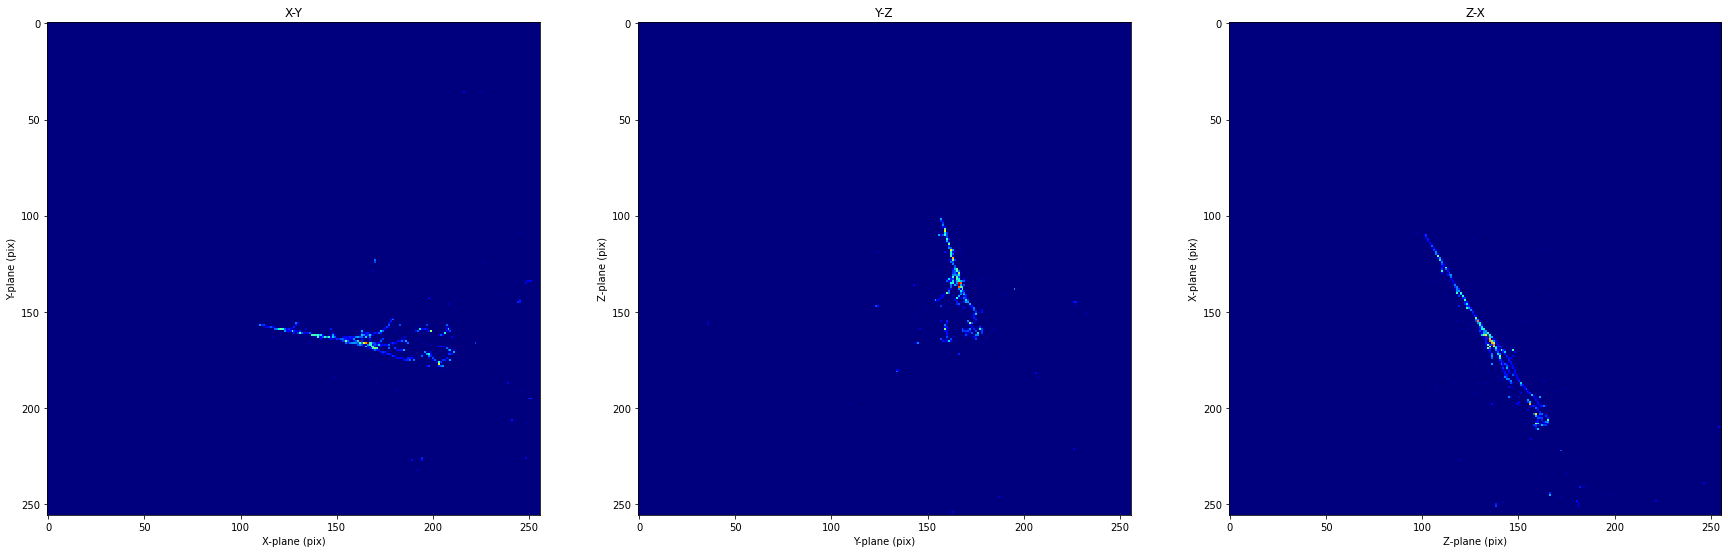

In [10]:
labels=["X-Y","Y-Z","Z-X"]
ilist= toimage(images[0])
fig = plt.figure(figsize=(30,10))

for index, image in enumerate(ilist):

    plt.subplot(1,3,index+1)
    #Show the image with imshow:
    plt.imshow(image, interpolation='none',cmap='jet')
    plt.xlabel('{}-plane (pix)'.format(labels[index].split("-")[0]))
    plt.ylabel('{}-plane (pix)'.format(labels[index].split("-")[1]))
    plt.title(labels[index])
fig.savefig("lar_planes.png")

---
### Truth information

Real data in a neutrino experiment does not come with labels, but since our dataset is simulated, we have the **truth level information** of the particles. We load the truth dataset here.

In [11]:
truth = np.load("LArTPC_truth_90k.npy")

We have eight truth arrays present in the dataset

- The particle ID (particle type ID as defined by the [particle data group](https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf))
    - 11   : 'electron',
    - 22   : 'photon',
    - 13   : 'muon',
    - 211  : 'pion',
    - 2212 : 'proton'
- The total momentum (p) of the initial particle in MeV
- The x component (px) of momentum in MEV
- The y component (py) of momentum in MEV
- The x component (pz) of momentum in MEV
- The x position of the production of the particle in cm
- The y position of the production of the particle in cm
- The z position of the production of the particle in cm


In [12]:
name_map = {11: 'electron', 22: 'photon', 13: 'muon', 211: 'pion', 2212: 'proton'}

In [13]:
p_id , p_ptot, p_px, p_py, p_pz, p_x, p_y, p_z= (truth[:,i] for i in range(truth.shape[1]))

In [14]:
truth.shape

(90000, 8)

# Project

For the project are required to perform an in depth investigation of the image dataset, and design **two** machine learning techniques from the dataset. The first tasks are **compulsary** where you are required explore the data and create an algorithm to identify/classify the particle in each event.  

## Task 0: Data exploration
* Explore a few images from each particle type, trying to identify how the particles are different between categories. Explore how the images change with different initial momenta. Remember that each event has three 2D images which should be veiwed simultaneously to get the full picture.
* Explore the truth information to get an idea of the dataset composition.

## Task 1: Image classification
* Create an algorithm to identify each event as being from one of five types of particles present in the datase
* You are strongly encouraged to use a convolutional neural network (CNN) classifier on the images, though this is not compulsary.
* Explore different architectures for the model, and explain in detail your choice of model, and the final parameters chosen. Consider doing a robust hyperparameter search.
* Explore the results and documents your findings. Ask as many questions about your model as you can, and document your findings.
    * Which particles are easy to identify, and which are not? 
    * What are the physics reasons for why some particles are similar?
    * Is there a dependence on particle position or momentum in your classifier for certain particle types?
    * Can you come up with a selection which gives good paricle purity?

## Task 2: Choose from one (or several) of these
Pick an additional task from this set, or come up with your own study that is not listed here. You should follow a similar approach as to **Task 1** above, but without as much detail needed. Consider *Task0 and Task 1* to be with 70% and *Task 2* to be worth the remaining *30%*.

* Create a regression algorithm which predicts the particle momentum for electrons, either the total momentum, or the px, py and pz. Determine the quality of the regression trained on electrons on photons. Explain the performace.
* Create a regression algorithm which predicts the x, y and z position of protons
* Create an autoencoder (AE) to reduce noise in the detector images. Do injection tests of random noise with different intensities to check your results. Some code to generate noise can be found in the [Keras AE tutorial](https://blog.keras.io/building-autoencoders-in-keras.html)
* Create a variable autoencoder (VAE) on the images for image generation of a paricular type. Try and make it conditional on momentum and position.
* _Etc._

To complete this project, you should:
* Perform **Task 0 and 1** and an additional task from **Task 2** (but not necessarily restricted to just these), label/number your studies, discuss the results, and compare their relative merits.
    * If you do any neat studies that don't result in a classification variable, _e.g._ image generation, that still very much counts!
* **Submit your Jupyter notebook** as a "report." See the comments below on documentation,
    
When doing each of your studies, you should try to follow the below steps (where it makes sense; rough weight in marking indicated in parentheses):

1. **Data exploration and preprocessing (10%):** Inspect the datasets; visualise the data in an appropriate way; study the composition of the dataset; perform any necessary preprocessing.
2. **Model selection (30%):** Choose a promising approach; construct the machine learning model; optimise the relevant hyperparameters; train your chosen model.
3. **Performance evaluation (20%):** Evaluate the model in a way that gauges its ability to generalise to unseen data; compare to other approaches; identify the best approach. 
4. **Discussion, style throughout (40%):** Discuss the reasoning or intuition behind your choices; the results you obtain through your studies; the relative merits of the methods you have developed, _etc._ Similarly, make sure that you write efficient code, document your work, clearly convey your results, and convince us that you have mastered the material.


That is, **you should submit, by Friday 3rd December 2020 at 4pm:**
* your report notebook via Turnitin.
    

For all task we're not looking for exceptional performace and high scores (although those are nice too), **we're mostly concerned with _best practices:_** If you are careful and deliberate in your work, and show us that you can use the tools introduced in the course so far, we're happy!

Training all of these models in sequence takes a very long time so **don't spend hours on training hundreds of epochs.** Be conservative on epoch numbers (30 is more than enough) and use appropiate techniques like EarlyStopping to speed things up.



### Documentation

Your reportnotebook should run without errors and give (mostly) reproducible results. It is important that **all** code is annotated and that you provide brief commentary **at each step** to explain your approach. Explain *why* you chose a given approach and *discuss* the results. You can also include any failed approaches if you provide reasonable explanation; we care more about you making an effort and showing that you understand the core concepts.

This is not in the form of a written report so do not provide pages of background material, but do try to clearly present your work so that the markers can easily follow your reasoning and can reproduce each of the steps through your analysis. Aim to convince us that you have understood the material covered in the course.

To add commentary above (or below) a code snippet create a new cell and add your text in "Markdown" format. Do not add any substantial commentary as a code comment in the same cell as the code. To change the new cell into markdown select from the drop down menu on the bar above the main window (the default is code)

---
# Lets get started

We need to define a few more things as we get started, but lets first split the data into 50K for training, and 40K reserved for testing

In [15]:
from sklearn.model_selection import train_test_split 

In [16]:
train_size = 50_000
x_train, x_test, truth_train, truth_test = train_test_split(images,truth,train_size=train_size,random_state=11)

## Special notes for traning on sparse matrices

Since we are using sparce matrices instead of dense ones, we need to tweak the way we **train**, **evaluate**, and **predict** from our model. This is because each of these steps requires the data to be **dense**, and we will run into the previous mentioned memory issues very quickly.


The solution for this is by using a **data generator** which will only load the dense data in batches. I give the function below.

The `nn_batch_generator` takes in the input data `X_data`, labels `y_data` and `batch_size` and creates a mini dense batch based on the `batch_size`. The `yield` keyword is a type of `return` function but which allows the method to keep running. Since we usually train on small batches (e.g. `32` events per batch) the data should be able to fit in memory.

In [17]:
def nn_batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].todense()
        y_batch = y_data[index_batch]
        counter += 1
        yield np.array(X_batch),y_batch
        if (counter > number_of_batches):
            counter=0

In [18]:
y = next(nn_batch_generator(x_train, truth_train[:,0], 32))[1]
y.shape

(32,)

Below is an example of passing the generator itself into the fit method. Because the generator would run forever, we need to use the `steps_per_epoch` parameter to tell the training when to stop (i.e, it reached the end of the data). We therefore set `steps_per_epoch` to the number of training entries divided by the batch size. In this case I set 5000 entries aside for the validation set.

**Note these are just examples taken from my own notebooks so don't expect to just work out the box for you**
```
validation_slice=5000
batch_size=32
history_cnn = cnn.fit(nn_batch_generator(x_train[:-validation_slice],y_labels[:-validation_slice],batch_size=batch_size),
                      epochs=20,
                      steps_per_epoch=int((50000-validation_slice)/batch_size),
                      validation_data=(x_train[-valdation_slice:], y_labels[-validation_slice:]))

```


Similarly predict and evaluate methods take generators with the `steps` parameter to end the evalutation

```
cnn.predict(nn_batch_generator(x_train[-5000:], y_train_labels[-5000:],batch_size=50),steps=5000/50)
```

```
cnn.evaluate(nn_batch_generator(x_test, y_train_labels,batch_size=50),steps=len(cc)/50)
```



### Finally a note on training 
We are training on a huge amount of data in practice, so expect the training to be **very very slow!!!**. I was clocking a single CNN training with 30 epochs at around 90 minutes on my CPU. I would recommend trying to run hyperparemer tests at night while you are sleeping, or alternatively if you must run from the CP labs, run them on a smaller set of 5K samples, with 500 validation. However, note that although the smaller trainings may allow you to explore different parameters more quickly, it won't nessesarily translate to the big dataset as easily, so at some point you will want to launch some big trainings on networks you find promissing. Remember to document your process as much as possible!

It is absolutely **essential** that you use callbacks to reduce the training time
* Use ReduceLROnPlateau if the training has not improved after a number of epochs
* Use EarlyStopping to exit the training if it has not improved after a number of epochs (should be a larger number than what is used on ReduceLROnPlateau)
* Use ModelCheckpoint to save the *best* model to a unique file. You can then use keras `load_model` (already imported for you) to load the saved model and not have to retrain if you close the notebook. Alternatively you can save any model with `save_model`.

In [19]:
from tensorflow.python.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau



**If the project description is unclear, or if you experience any technical issues, please do let me know as quickly as possible. I can send around clarifications if I think it would be to the benefit of the entire class.**

---

**Your code below**

---

In [20]:
def show_images(images, title):
    labels=["X-Y","Y-Z","Z-X"]
    ilist= toimage(images[0])
    fig = plt.figure(figsize=(30,10))

    for index, image in enumerate(ilist):

        plt.subplot(1,3,index+1)
        #Show the image with imshow:
        plt.imshow(image, interpolation='none',cmap='jet')
        plt.xlabel('{}-plane (pix)'.format(labels[index].split("-")[0]))
        plt.ylabel('{}-plane (pix)'.format(labels[index].split("-")[1]))
        plt.title(labels[index])
        plt.suptitle(title)
    plt.show()

## Task 0: Data exploration
* Explore a few images from each particle type, trying to identify how the particles are different between categories. Explore how the images change with different initial momenta. Remember that each event has three 2D images which should be veiwed simultaneously to get the full picture.
* Explore the truth information to get an idea of the dataset composition.

In [21]:
# normalise images
images /= np.max(images)

In [22]:
# get the index of each particle type
electron_idx = np.where(p_id == 11)[0]
photon_idx = np.where(p_id == 22)[0]
muon_idx = np.where(p_id == 13)[0]
pion_idx = np.where(p_id == 211)[0]
proton_idx = np.where(p_id == 2212)[0]

In [23]:
# randomly pick some images from each type
num_images = 2
electrons = np.random.choice(electron_idx, num_images)
photons = np.random.choice(photon_idx, num_images)
muons = np.random.choice(muon_idx, num_images)
pions = np.random.choice(pion_idx, num_images)
protons = np.random.choice(proton_idx, num_images)

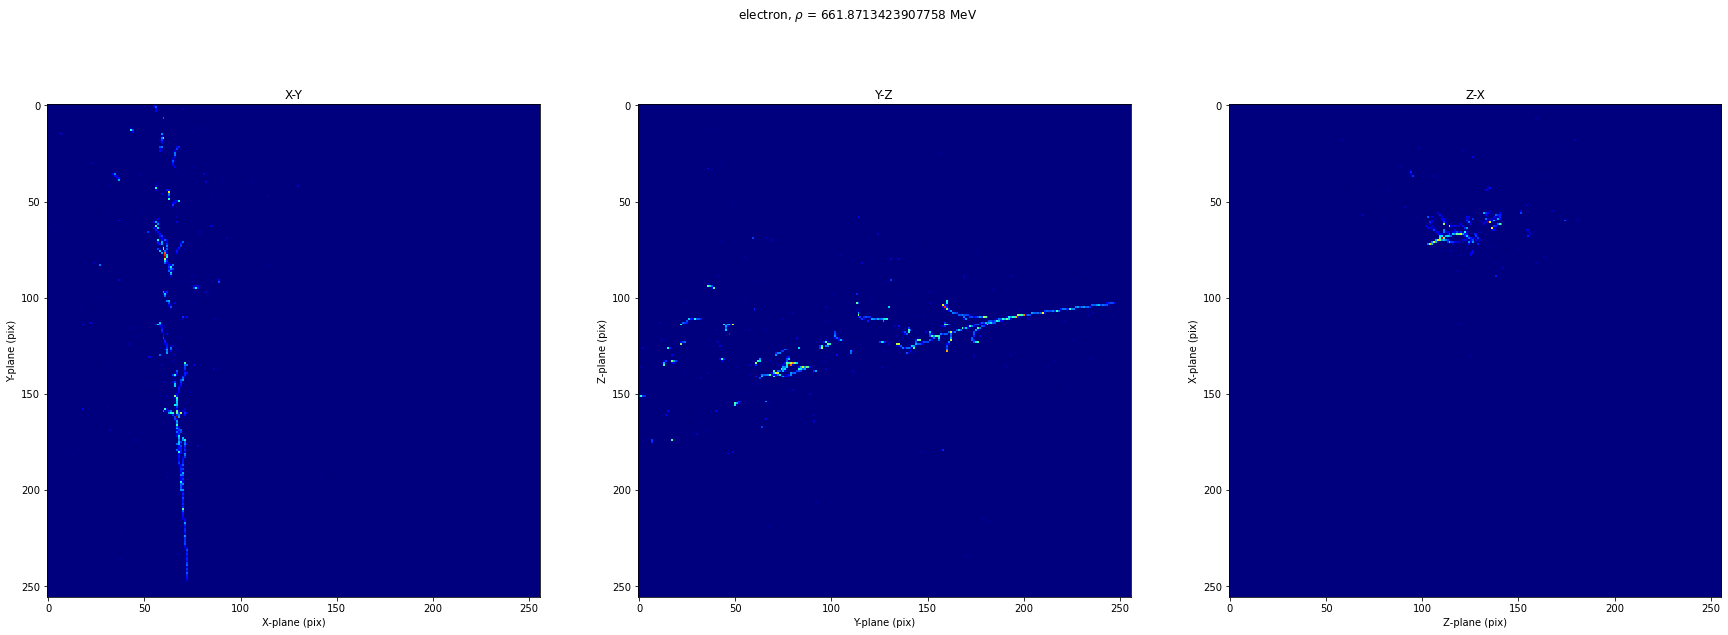

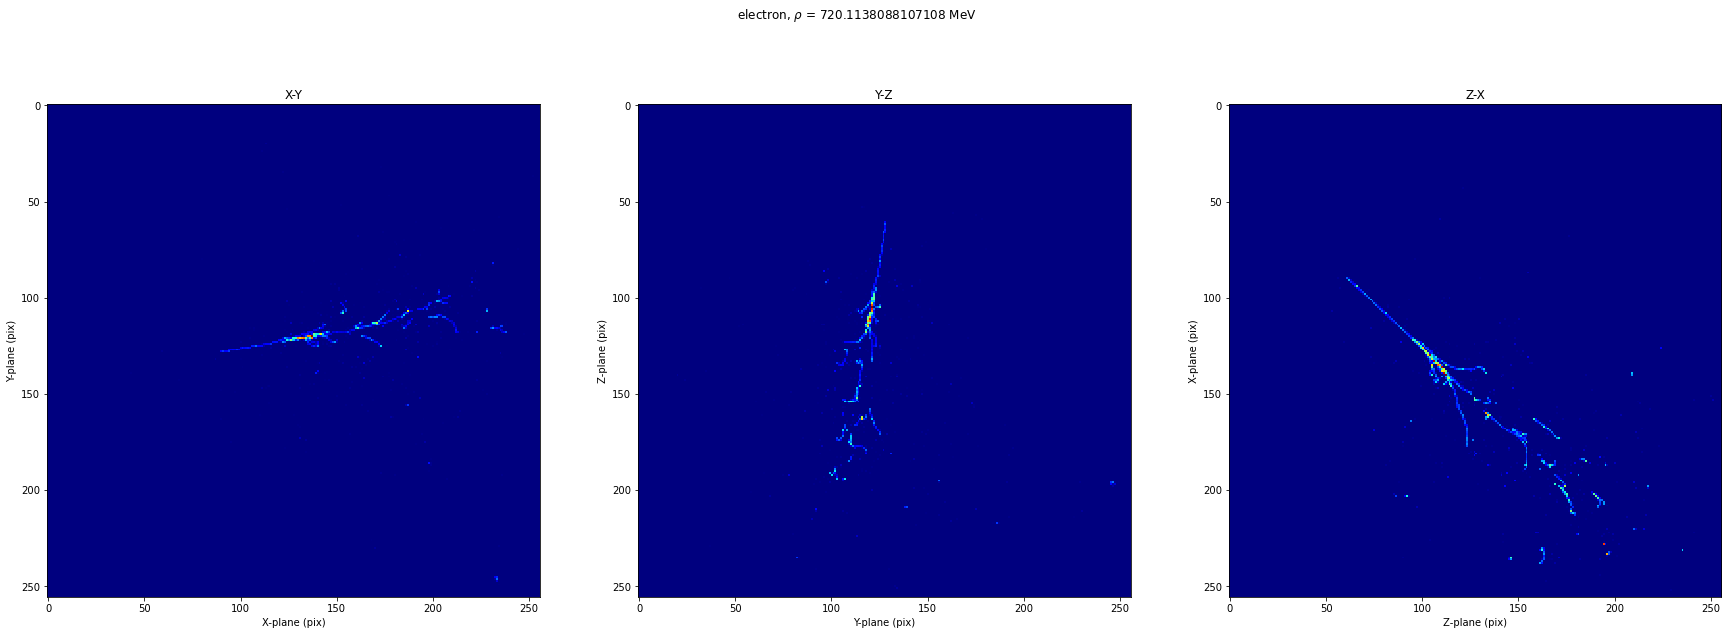

In [24]:
# electrons
e_ims = images[electrons]
e_ps = p_ptot[electrons]
for e_im, e_p in zip(e_ims, e_ps): show_images(e_im, fr"electron, $\rho$ = {e_p} MeV")

Electrons have long straight paths with branches at points of decay. The electron with higher momentum has a longer path before decaying than the lower momentum electron

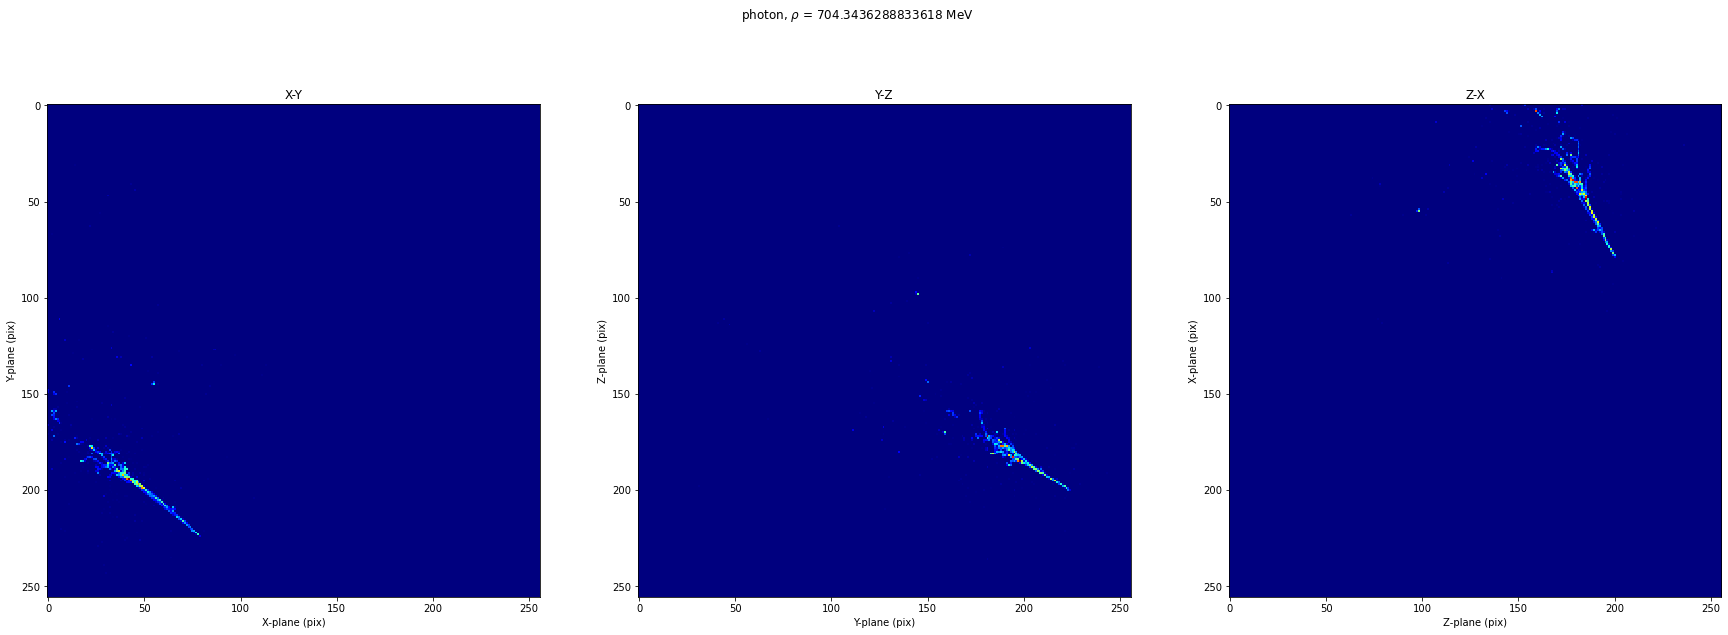

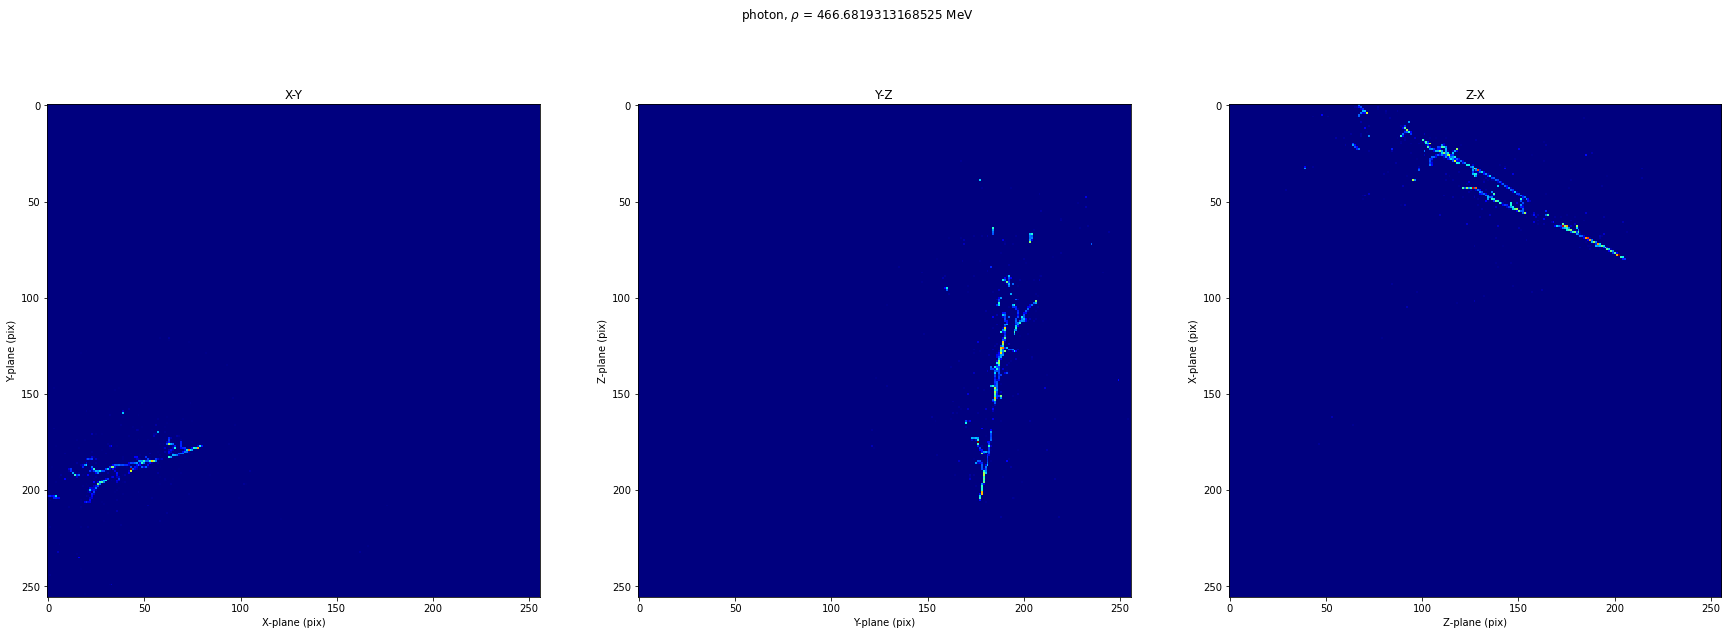

In [25]:
# photons
gamma_ims = images[photons]
gamma_ps = p_ptot[photons]
for gamma_im, gamma_p in zip(gamma_ims, gamma_ps): show_images(gamma_im, fr"photon, $\rho$ = {gamma_p} MeV")

The photons travel for a distance in a straight line before decaying into pair production. The distance the photon travels before decaying depends on the momentum of the photon. The larger momentum photon traveks further before decaying

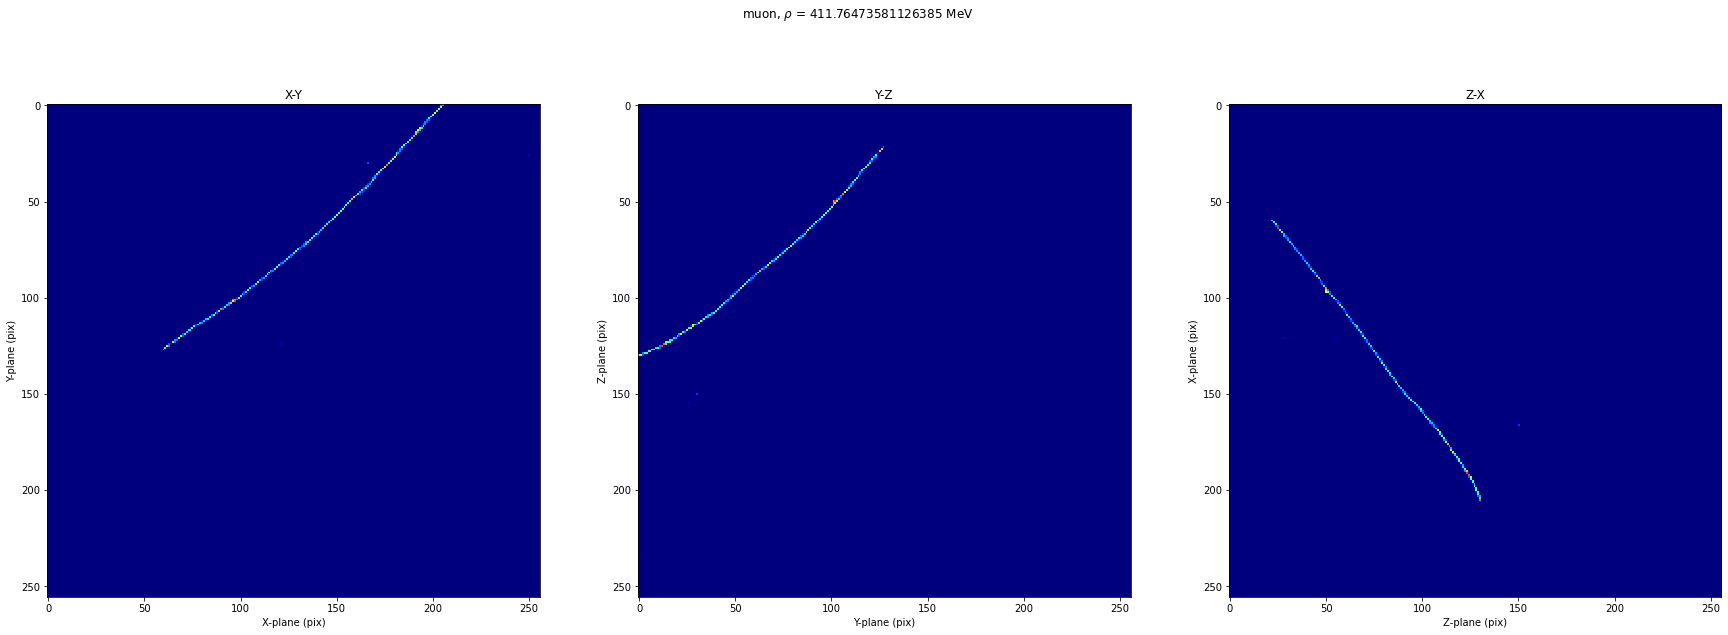

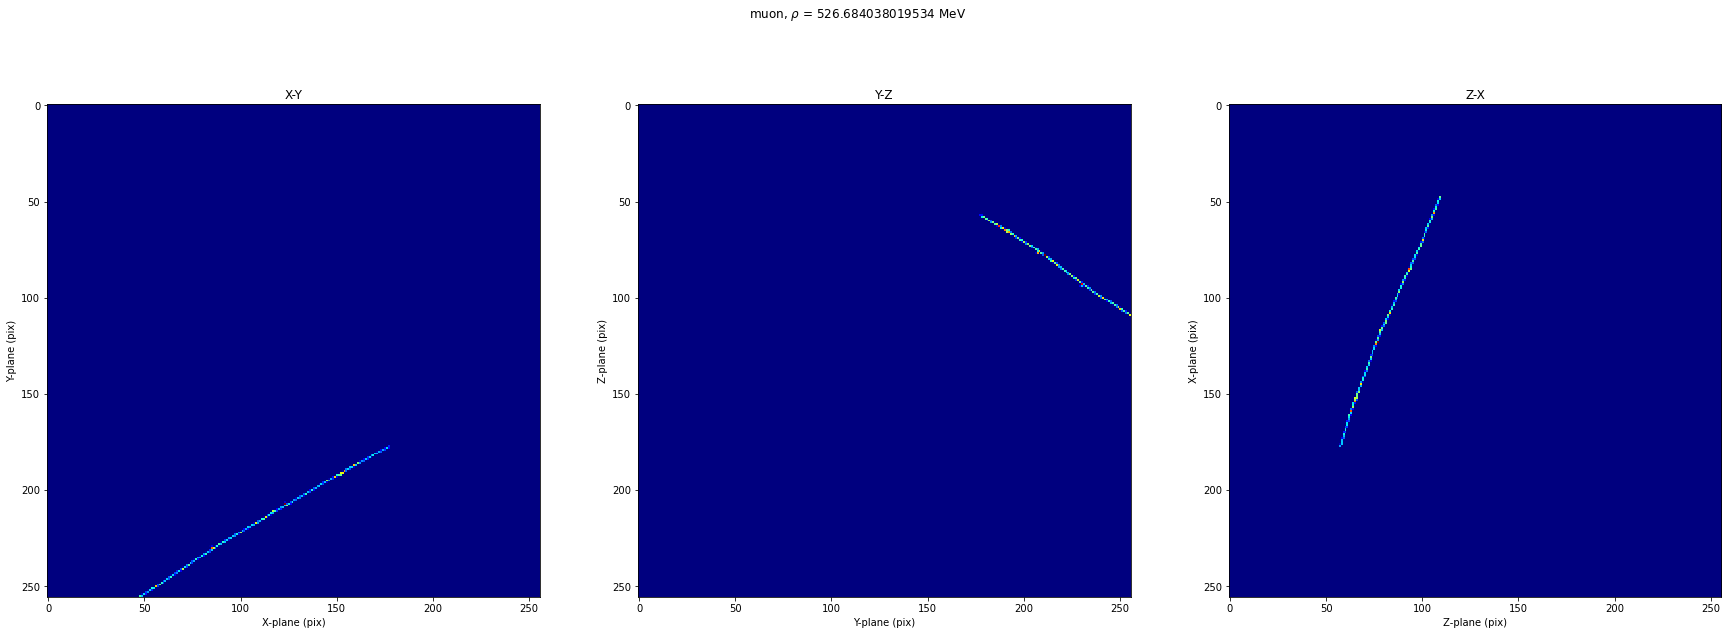

In [26]:
# muons
m_ims = images[muons]
m_ps = p_ptot[muons]
for m_im, m_p in zip(m_ims, m_ps): show_images(m_im, fr"muon, $\rho$ = {m_p} MeV")

muon paths are long slightly curved lines that decay without branching at high momentums and observe some branching at the point of decay in lower momentums

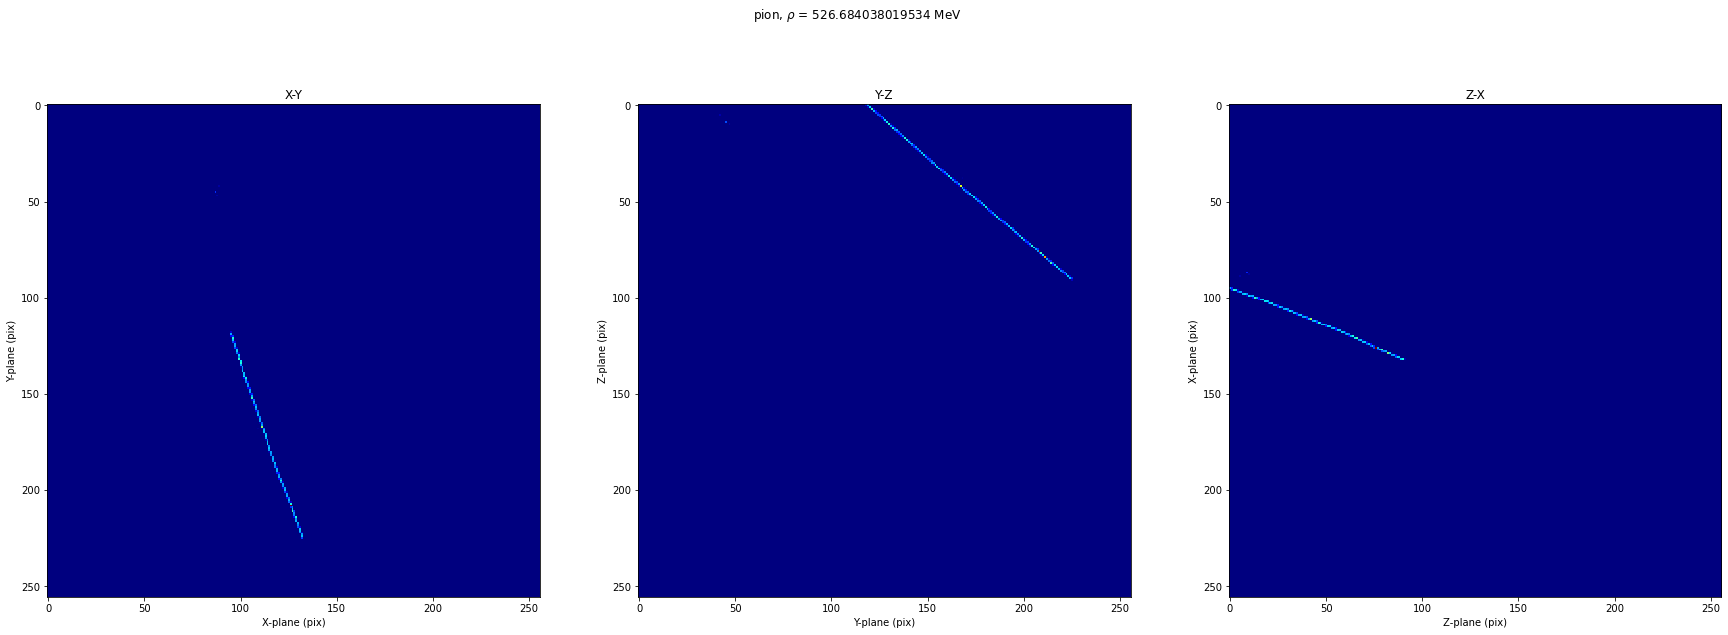

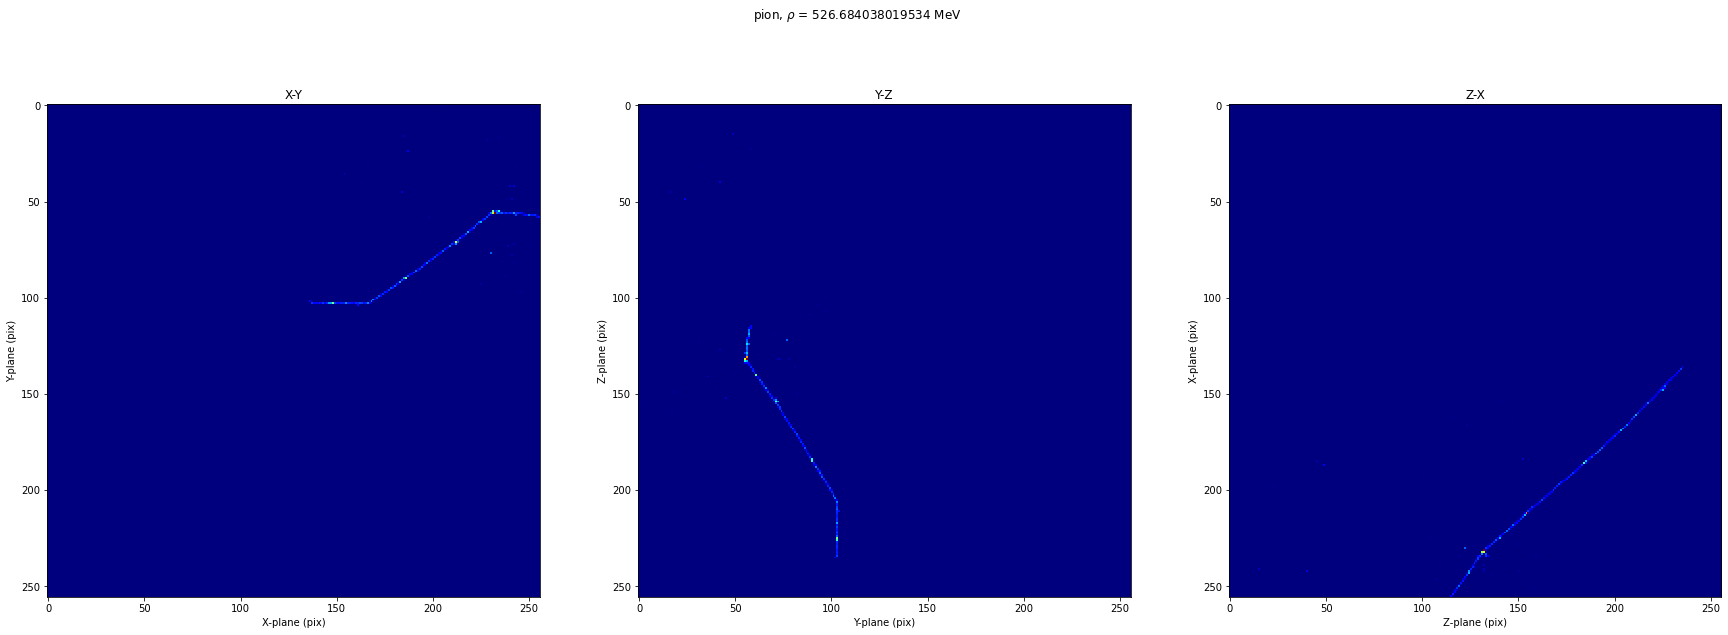

In [27]:
# pions
pi_ims = images[pions]
pi_ps = p_ptot[pions]
for pi_im, pi_p in zip(pi_ims, pi_ps): show_images(pi_im, fr"pion, $\rho$ = {m_p} MeV")

Pions observe branching or paths changing direction at the point of decay.

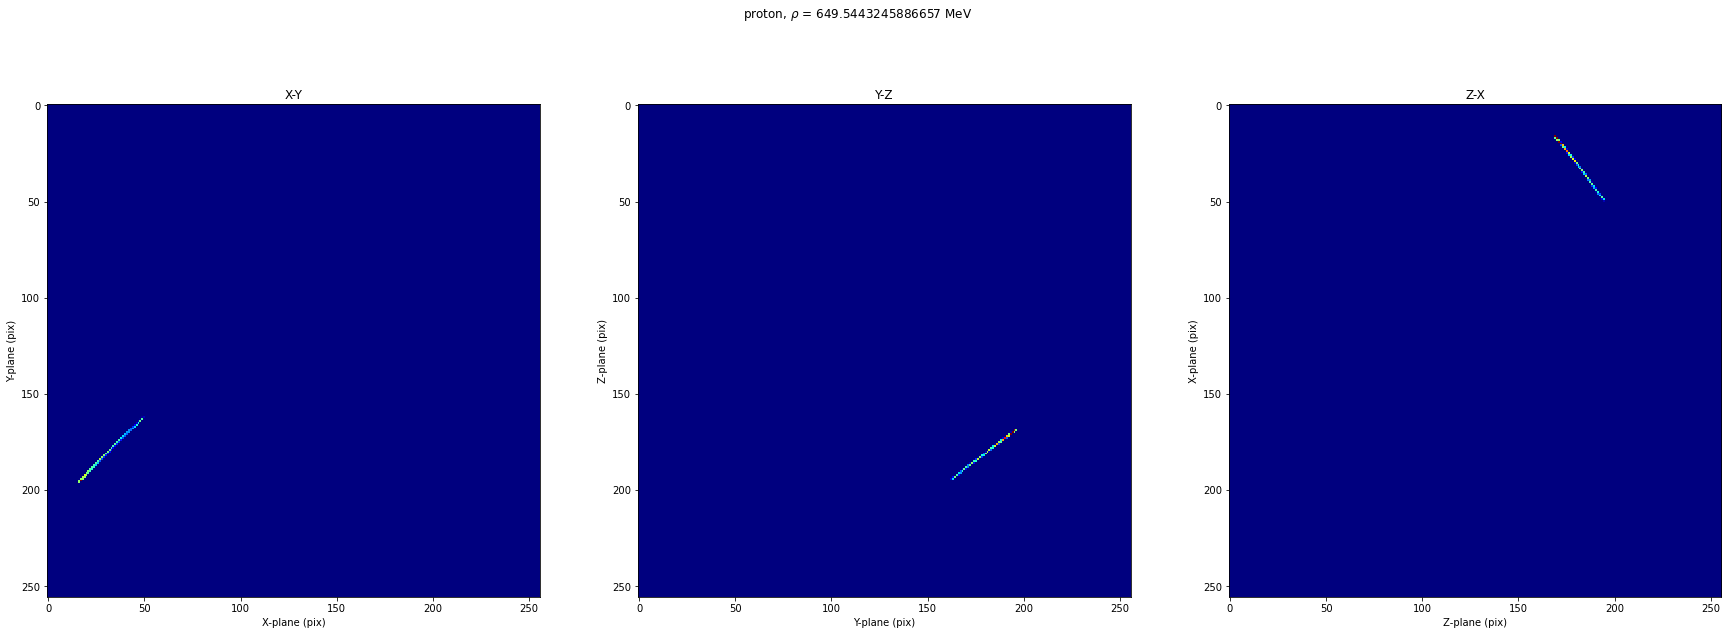

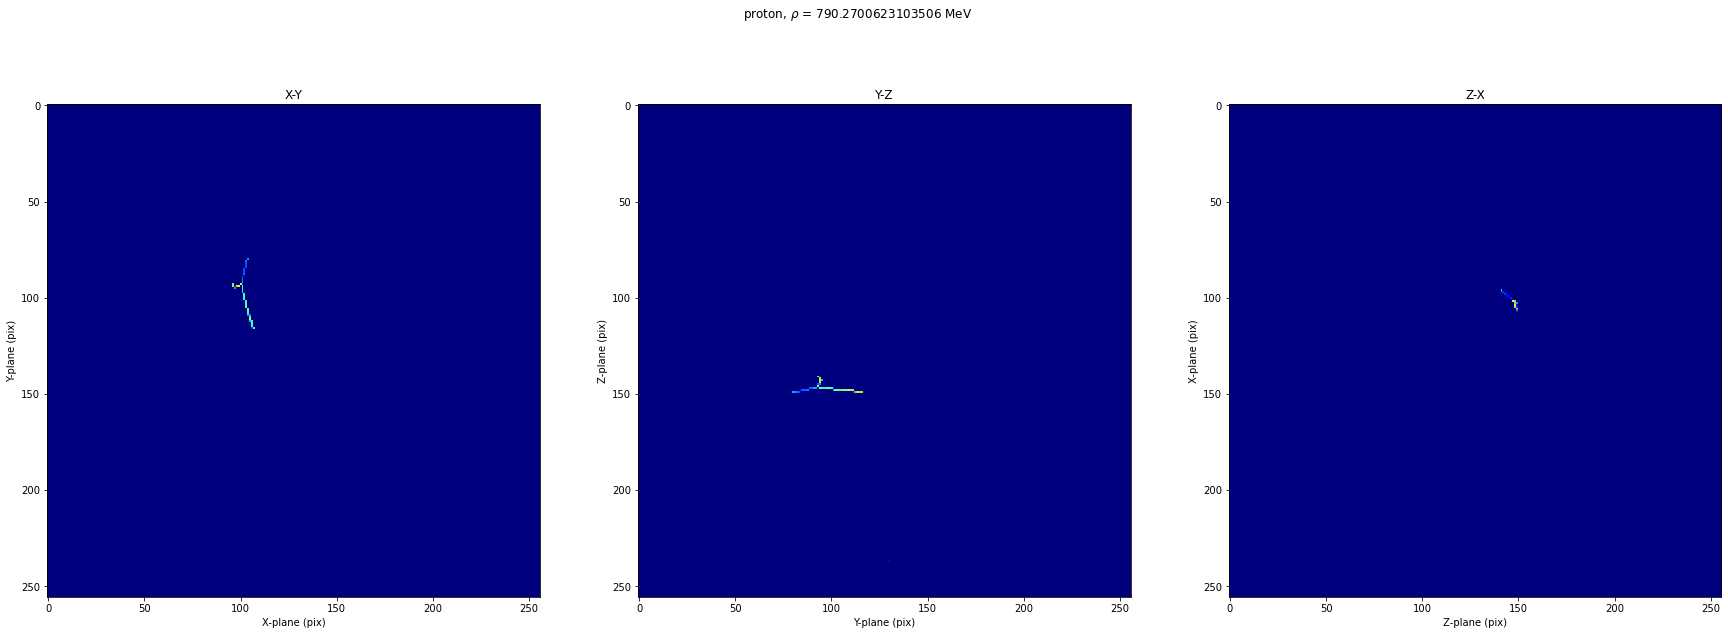

In [28]:
# protons
p_ims = images[protons]
p_ps = p_ptot[protons]
for p_im, p_p in zip(p_ims, p_ps): show_images(p_im, fr"proton, $\rho$ = {p_p} MeV")

Protons are medium length straight lines with no branching at the point of decay

## Task 1: Image classification
* Create an algorithm to identify each event as being from one of five types of particles present in the datase
* You are strongly encouraged to use a convolutional neural network (CNN) classifier on the images, though this is not compulsary.
* Explore different architectures for the model, and explain in detail your choice of model, and the final parameters chosen. Consider doing a robust hyperparameter search.
* Explore the results and documents your findings. Ask as many questions about your model as you can, and document your findings.
    * Which particles are easy to identify, and which are not? 
    * What are the physics reasons for why some particles are similar?
    * Is there a dependence on particle position or momentum in your classifier for certain particle types?
    * Can you come up with a selection which gives good paricle purity?

In [29]:
# factory to produce models for hyperparameter training
def cnn_factory(conv_layers: Sequence, strides: Sequence, pooling_layers: Sequence):
    final_size = 256
    input_ = Input(shape=(196608,))
    x = Reshape((256, 256, 3))(input_)
    x = BatchNormalization()(x)
    for f, s, p in zip(conv_layers, strides, pooling_layers):
        x = Conv2D(f, (3,3), strides=s, padding='same', activation=LeakyReLU())(x)
        x = MaxPooling2D(pool_size=(p,p))(x)
        final_size /= (s*p)
    x = Dense(conv_layers[-1] * final_size ** 2, activation=LeakyReLU())(x)
    x = Dense(conv_layers[-1] * final_size, activation=LeakyReLU())(x)
    x = Flatten()(x)
    output = Dense(5, activation='sigmoid')(x)
    cnn = Model(inputs=input_, outputs=output)
    return cnn

In [30]:
# generate a list of hyperparameters to iterate through

testing_values = {
    "conv layers": [[8, 16, 24, 32], [4, 8, 12, 16]],
    "pooling layers": [[2, 2, 2, 2], [4, 2, 2, 2]],
    "strides": [[1, 1, 1, 1]],
    "epochs": [20],
}
param_grid = list(ParameterGrid(testing_values))
for i, set in enumerate(param_grid):
    # removing any combinations that result in final dense layers that are too large to handle in memory
    reduction = np.prod(set['strides'])*np.prod(set['pooling layers'])
    dense_size = set['conv layers'][-1] * (256 / reduction) ** 3
    if dense_size > 100_000:
        param_grid.remove(set)
print(len(param_grid))


3


In [31]:
# create the y labels from truth particle id
train_ids = truth_train[:,0]
ids = np.unique(p_id)
map = dict(enumerate(ids))
map = dict((v,k) for k,v in map.items())
y_labels = np.vectorize(map.get)(train_ids)

# compiling the model and including callbacks to prevent model running too long
monitor = 'loss'
patience = 5
filepath = '/tmp/checkpoint/model.hdf5'
# create reduce LR callback
reduce_lr = ReduceLROnPlateau(monitor=monitor, patience=patience)

# create early stopping callback, must have a larger patience than reduce_lr
early_stopping = EarlyStopping(monitor=monitor, patience=patience*2)

# create the model checkpoint callback
model_checkpoint = ModelCheckpoint(filepath=filepath, monitor=monitor)

In [30]:
validation_slice = 5000
histories = []
# hyperparameter training, running a model for each set in the parameter grid
for i, set in enumerate(param_grid):
    cnn = cnn_factory(set['conv layers'], set['strides'], set['pooling layers'])
    plot_model(cnn, f"models/model{i}.png", show_shapes=True)
    cnn.compile('adam', loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
    batch_size = 128
    epochs = set['epochs']
    steps_per_epoch  = (train_size - validation_slice) // batch_size
    history = cnn.fit(nn_batch_generator(x_train[:-validation_slice],y_labels[:-validation_slice],batch_size=batch_size),
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=(x_train[-validation_slice:], y_labels[-validation_slice:]),
                    callbacks=[reduce_lr, early_stopping, model_checkpoint], shuffle=True)
    histories.append(history.history)
    np.save(f"history{i}.npy", history.history)
np.save("histories.npy",histories)

Instructions for updating:
Colocations handled automatically by placer.
Epoch 1/20
351/351 [==============================] - ETA: 0s - batch: 175.0000 - size: 128.0000 - loss: 0.8957 - accuracy: 0.5971

C:\Users\Gamer2021\anaconda3\envs\daml\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


351/351 [==============================] - 63s 156ms/step - batch: 175.0000 - size: 128.0000 - loss: 0.8957 - accuracy: 0.5971 - val_loss: 0.6973 - val_accuracy: 0.6708 - lr: 0.0010
Epoch 2/20
351/351 [==============================] - 55s 156ms/step - batch: 175.0000 - size: 127.8405 - loss: 0.6790 - accuracy: 0.6928 - val_loss: 0.6614 - val_accuracy: 0.6850 - lr: 0.0010
Epoch 3/20
351/351 [==============================] - 55s 155ms/step - batch: 175.0000 - size: 127.8405 - loss: 0.6232 - accuracy: 0.7153 - val_loss: 0.6479 - val_accuracy: 0.6930 - lr: 0.0010
Epoch 4/20
351/351 [==============================] - 55s 156ms/step - batch: 175.0000 - size: 127.8405 - loss: 0.5862 - accuracy: 0.7354 - val_loss: 0.6640 - val_accuracy: 0.6916 - lr: 0.0010
Epoch 5/20
351/351 [==============================] - 55s 156ms/step - batch: 175.0000 - size: 127.8405 - loss: 0.5601 - accuracy: 0.7489 - val_loss: 0.6428 - val_accuracy: 0.7162 - lr: 0.0010
Epoch 6/20
351/351 [==========================

Instructions for updating:
Colocations handled automatically by placer.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 196608)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 256, 256, 3)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 96)        55392     
_______________________________________________________

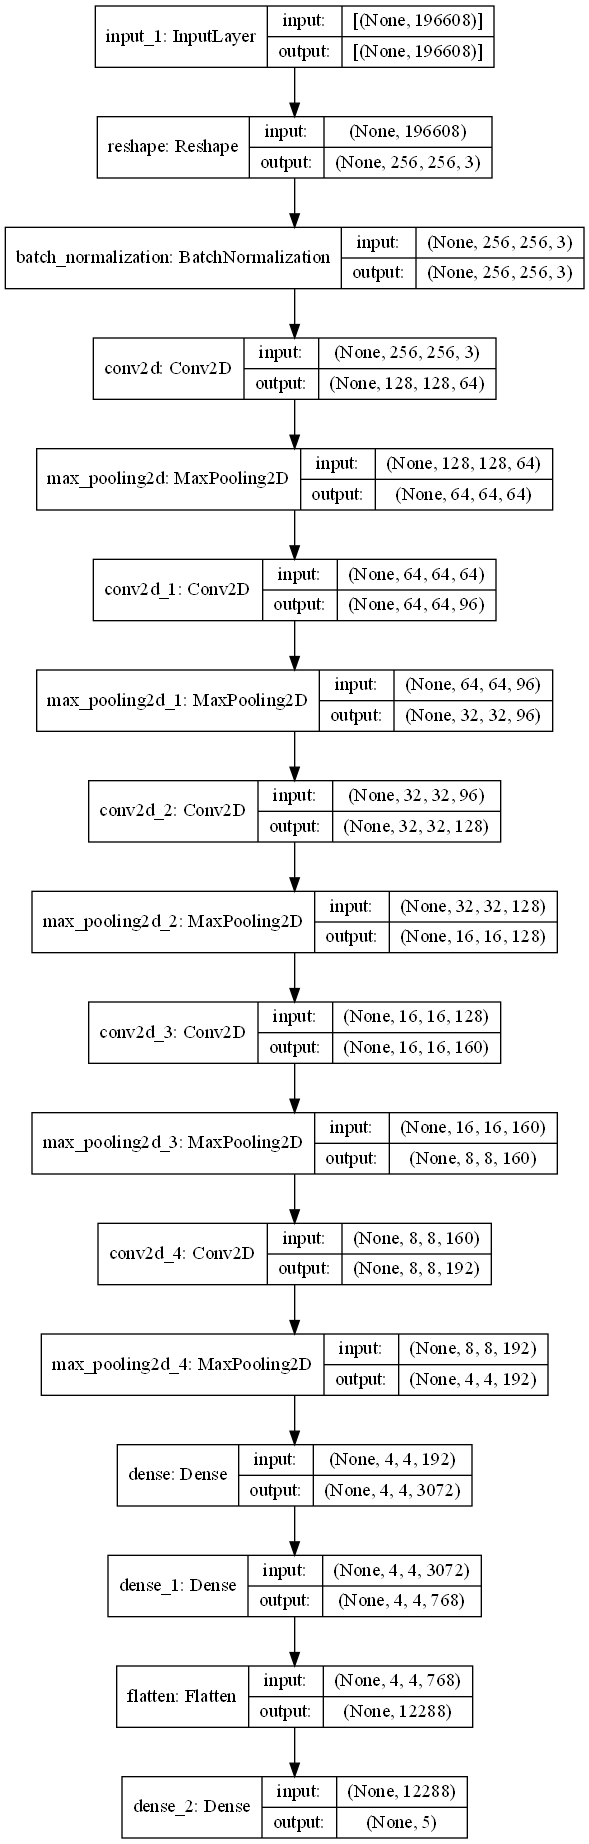

In [32]:
# model based off the one used by microBooNe
input_ = Input(shape=(196608,))
x = Reshape((256, 256, 3))(input_)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), strides=2, padding='same', activation=LeakyReLU())(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(96, (3,3), padding='same', activation=LeakyReLU())(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, (3,3), padding='same', activation=LeakyReLU())(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(160, (3,3), padding='same', activation=LeakyReLU())(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(192, (3,3), padding='same', activation=LeakyReLU())(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dense(192 * 4 * 4, activation=LeakyReLU())(x)
x = Dense(192 * 4, activation=LeakyReLU())(x)
x = Flatten()(x)
output = Dense(5, activation='sigmoid')(x)
cnn = Model(inputs=input_, outputs=output)
cnn.summary()
plot_model(cnn, to_file="models/model.png", show_shapes=True)

In [33]:
# create the y labels from truth particle id
train_ids = truth_train[:,0]
ids = np.unique(p_id)
map = dict(enumerate(ids))
map = dict((v,k) for k,v in map.items())
y_labels = np.vectorize(map.get)(train_ids)

In [44]:
# compiling the model and including callbacks to prevent model running too long
monitor = 'loss'
patience = 5
filepath = '/tmp/checkpoint/model.hdf5'
# create reduce LR callback
reduce_lr = ReduceLROnPlateau(monitor=monitor, patience=patience)

# create early stopping callback, must have a larger patience than reduce_lr
early_stopping = EarlyStopping(monitor=monitor, patience=patience*2)

# create the model checkpoint callback
model_checkpoint = ModelCheckpoint(filepath=filepath, monitor=monitor)


cnn.compile('adam', loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

validation_slice = 5000
batch_size = 128
epochs = 20
steps_per_epoch  = (train_size - validation_slice) // batch_size
history = cnn.fit(nn_batch_generator(x_train[:-validation_slice],y_labels[:-validation_slice],batch_size=batch_size),
                epochs=epochs,
                steps_per_epoch=steps_per_epoch,
                validation_data=(x_train[-validation_slice:], y_labels[-validation_slice:]),
                callbacks=[reduce_lr, early_stopping, model_checkpoint], shuffle=True)

(45000, 196608) (45000,)


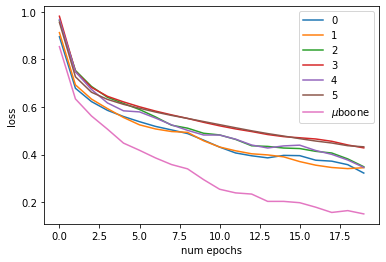

In [46]:
# finding the best model from the hyperparameter training and from the paper

# plot the losses
for i, h in enumerate(histories):
    plt.plot(h['loss'], label=i)
plt.plot(history.history['loss'], label=r'$\mu$boone')
plt.legend()
plt.xlabel("num epochs")
plt.ylabel("loss");

After running for initially 20 epochs, all models could be run for slightly longer to yield better losses (as they are still continuining to decrease) but the model based off of microBoonNe's shows significantly better loss reduction than the others. Therefore it makes sense to continue the analysis on the microboone model and discard the others. It may also be beneficial to rerun the model for 30 epochs instead of 20. 

In [47]:
# evaluate the model's performance

# evaluate on the training dataset
train_scores = cnn.evaluate(nn_batch_generator(x_train, y_labels,batch_size=50),steps=validation_slice/50)

# getting the y labels for the test set
test_ids = truth_test[:,0]
y_labels_test = np.vectorize(map.get)(test_ids)

test_scores = cnn.evaluate(nn_batch_generator(x_test, y_labels_test,batch_size=50),steps=validation_slice/50)

print(f"""test loss: {test_scores[0]}
test accuracy: {test_scores[1]}

train loss: {train_scores[0]}
train accuracy: {train_scores[1]}""")
y_pred = cnn.predict(nn_batch_generator(x_train[-validation_slice:], y_labels[-validation_slice:],batch_size=50),steps=validation_slice/50)


test loss: 1.5005233243107796
test accuracy: 0.758400022983551

train loss: 0.17364330619573592
train accuracy: 0.949999988079071


C:\Users\Gamer2021\anaconda3\envs\daml\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


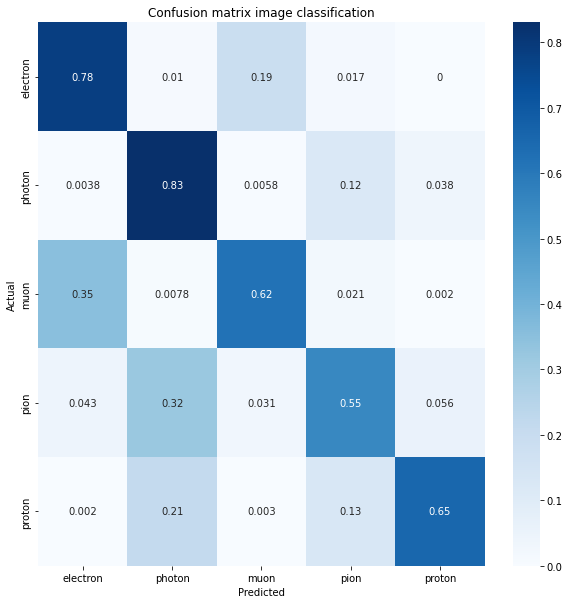

In [48]:
# generate the confusion matrix
most_probable = np.argmax(y_pred,axis=1)

conf_mat = confusion_matrix(y_labels[-validation_slice:], most_probable, normalize='true')
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, cmap=plt.cm.Blues)
ax.set_xticklabels(name_map.values())
ax.set_yticklabels(name_map.values())
ax.set_title("Confusion matrix image classification")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.savefig("conf_mat.png")

muons and electrons are often confused for one another which makes sense because muons and electrons are both leptons and therefore
similar patterns.

photons are often predicted for pions and protons as these decays produce photons and photon pair production can produce.


Pions are rarely incorrectly predicted, due to the distinguishing kink that the others don't and the model can easily train on that.

## Task 2: Choose from one (or several) of these
Pick an additional task from this set, or come up with your own study that is not listed here. You should follow a similar approach as to **Task 1** above, but without as much detail needed. Consider *Task0 and Task 1* to be with 70% and *Task 2* to be worth the remaining *30%*.

* **Create a regression algorithm which predicts the particle momentum for electrons, either the total momentum, or the px, py and pz. Determine the quality of the regression trained on electrons on photons. Explain the performace.**
* Create a regression algorithm which predicts the x, y and z position of protons
* Create an autoencoder (AE) to reduce noise in the detector images. Do injection tests of random noise with different intensities to check your results. Some code to generate noise can be found in the [Keras AE tutorial](https://blog.keras.io/building-autoencoders-in-keras.html)
* Create a variable autoencoder (VAE) on the images for image generation of a paricular type. Try and make it conditional on momentum and position.
* _Etc._

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 196608)]          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 256, 256, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 3)       12        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 96)        5539

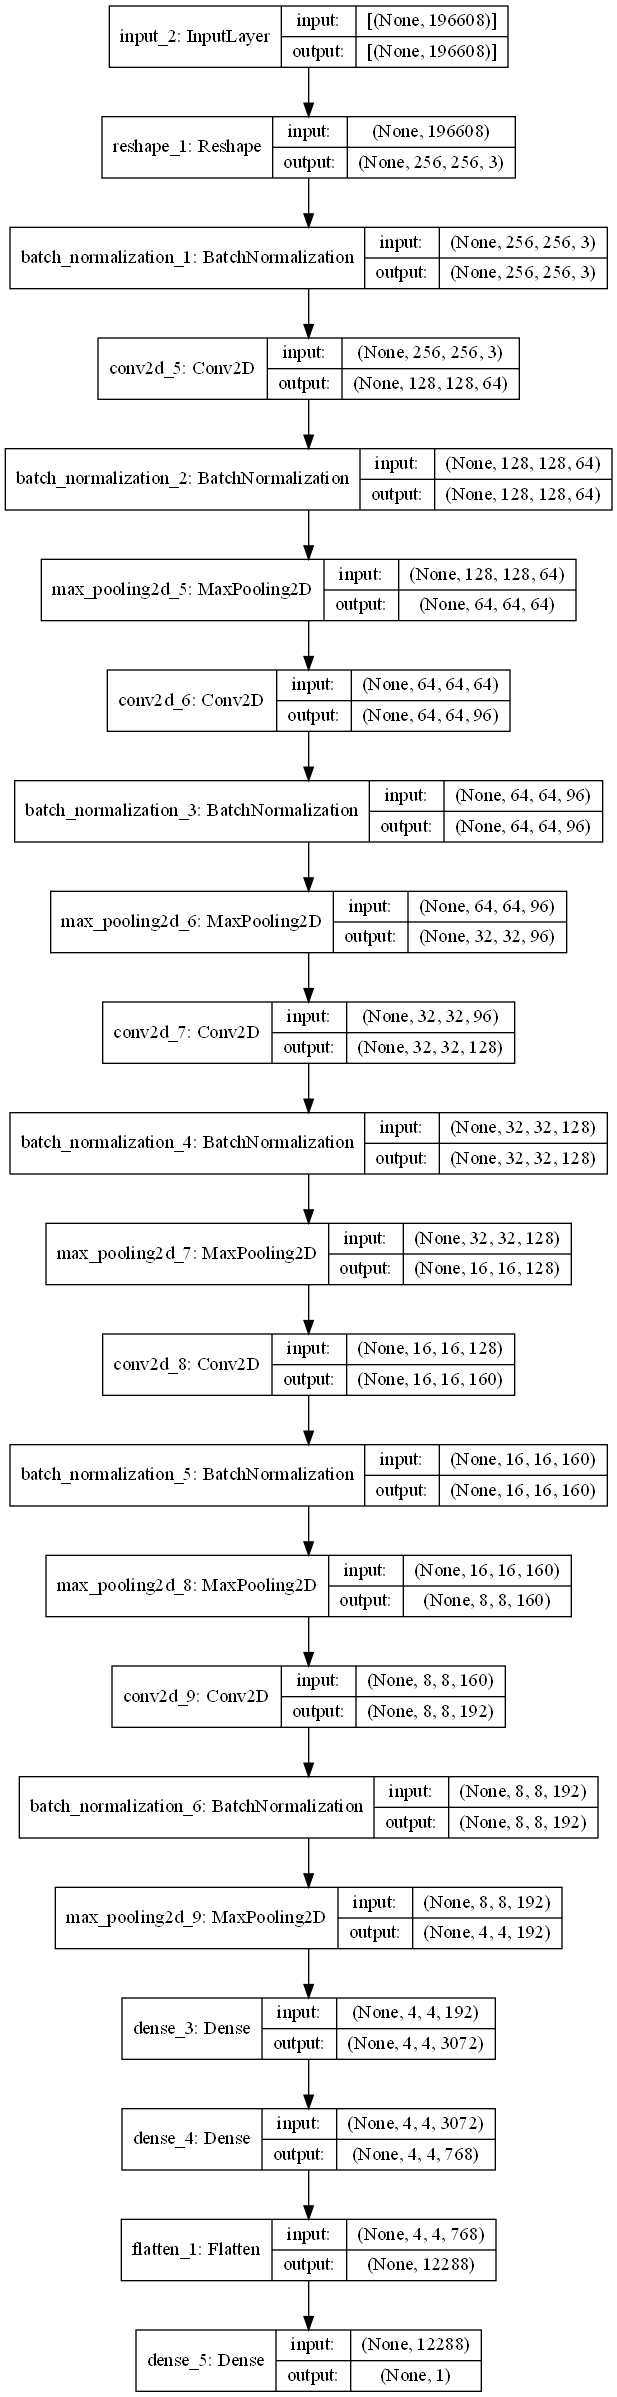

In [34]:
# reuse the cnn from above with more epochs and a dense output of 1 instead of 5
# model based off the one used by microBooNe
input_ = Input(shape=(196608,))
x = Reshape((256, 256, 3))(input_)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), strides=2, padding='same', activation=LeakyReLU())(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(96, (3,3), padding='same', activation=LeakyReLU())(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, (3,3), padding='same', activation=LeakyReLU())(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(160, (3,3), padding='same', activation=LeakyReLU())(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(192, (3,3), padding='same', activation=LeakyReLU())(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dense(192 * 4 * 4, activation=LeakyReLU())(x)
x = Dense(192 * 4, activation=LeakyReLU())(x)
x = Flatten()(x)
output = Dense(1, activation='linear')(x)
cnn = Model(inputs=input_, outputs=output)
cnn.summary()
plot_model(cnn, to_file="models/regression.png", show_shapes=True)

In [64]:
# prepare the position data for analysis
# get momentum of all the electrons
p_id_train = truth_train[:,0]
p_id_test = truth_test[:,0]
electron_idx_train = np.where(p_id_train == 11)[0]
electron_idx_test = np.where(p_id_test == 11)[0]
p_tot_train = truth_train[electron_idx_train][:,1]
p_tot_test = truth_test[electron_idx_test][:,1]
# normalise the data
y_train = p_tot_train / p_tot_train.max()
y_test = p_tot_test / p_tot_test.max()
# set aside an amount for validation
# compile using mean squared error

# using a smaller learning rate
cnn.compile(Adam(learning_rate=1e-3), loss='mean_absolute_percentage_error')
# train on 30 epochs
validation_slice = 5000
batch_size = 128
epochs = 30
steps_per_epoch  = (train_size - validation_slice) // batch_size
history = cnn.fit(nn_batch_generator(x_train[electron_idx_train][:-validation_slice],y_train[:-validation_slice],batch_size=batch_size),
                epochs=epochs,
                steps_per_epoch=steps_per_epoch,
                validation_data=(x_train[-validation_slice:], y_train[-validation_slice:]),
                callbacks=[reduce_lr, early_stopping, model_checkpoint], shuffle=True)

Epoch 1/30
351/351 [==============================] - ETA: 0s - batch: 175.0000 - size: 126.1795 - loss: 21.3292

C:\Users\Gamer2021\anaconda3\envs\daml\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


351/351 [==============================] - 97s 270ms/step - batch: 175.0000 - size: 126.1795 - loss: 21.3293 - val_loss: 91.6264 - lr: 0.0010
Epoch 2/30
351/351 [==============================] - 92s 262ms/step - batch: 175.0000 - size: 126.1795 - loss: 14.5969 - val_loss: 97.5039 - lr: 0.0010
Epoch 3/30
351/351 [==============================] - 106s 303ms/step - batch: 175.0000 - size: 126.1795 - loss: 14.9935 - val_loss: 81.1252 - lr: 0.0010
Epoch 4/30
351/351 [==============================] - 99s 283ms/step - batch: 175.0000 - size: 126.1795 - loss: 13.5350 - val_loss: 90.9639 - lr: 0.0010
Epoch 5/30
351/351 [==============================] - 113s 322ms/step - batch: 175.0000 - size: 126.1795 - loss: 11.2676 - val_loss: 87.8398 - lr: 0.0010
Epoch 6/30
351/351 [==============================] - 115s 328ms/step - batch: 175.0000 - size: 126.1795 - loss: 10.5475 - val_loss: 113.6273 - lr: 0.0010
Epoch 7/30
351/351 [==============================] - 95s 271ms/step - batch: 175.0000 - 

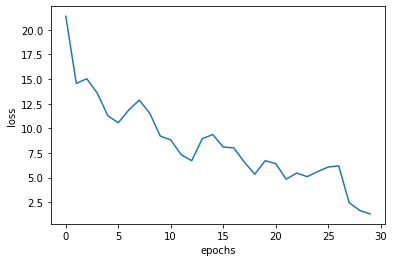

In [65]:
# plot the loss over time
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show();

loss decreases sharply at first and then slows down over time. More epochs would likely result in more loss until a certain point

In [66]:
y_pred_valid = cnn.predict(nn_batch_generator(x_train[-validation_slice:], y_train[-validation_slice:],batch_size=50),steps=validation_slice/50)
y_pred = cnn.predict(nn_batch_generator(x_test, y_test, batch_size=50), steps=len(y_test)/50)

In [67]:
test_scores = cnn.evaluate(nn_batch_generator(x_test, y_test,batch_size=50),steps=validation_slice/50)
print(f"test loss: {test_scores}")
diff = y_pred.flatten() - y_test
percentDiff = (diff / y_test) * 100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

print("mean: ", mean)
print("std: ", std)

test loss: 92.68282428741455
mean:  92.10901902032143
std:  150.32499193457193


Very large test loss and standard deviation suggests model has not trained very well. More epochs would solve this but also a model with more fully connected layers after the CNN would produce better results.